In [1]:
# Install required libraries
!pip install pandas scipy scikit-learn seaborn matplotlib

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import arff
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Upload the .arff file manually in Colab (click to upload 'Rice_Cammeo_Osmancik.arff')
from google.colab import files
uploaded = files.upload()

# Load the .arff file into a DataFrame
data, meta = arff.loadarff('Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)

# Decode byte data in columns (if necessary)
for col in df.columns:
    if df[col].dtype == 'O':
        df[col] = df[col].str.decode('utf-8')

# Check first few rows of the dataset to confirm successful loading
df.head()


Saving Rice_Cammeo_Osmancik.arff to Rice_Cammeo_Osmancik.arff


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,Cammeo
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,Cammeo
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,Cammeo
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,Cammeo
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,Cammeo


In [7]:
# Display descriptive statistics
print("Descriptive Statistics:")
print(df.describe())


Descriptive Statistics:
               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.100006         145.264465          59.532406   
25%    11370.500000   426.144753         174.353855          82.731695   
50%    12421.500000   448.852493         185.810059          86.434647   
75%    13950.000000   483.683746         203.550438          90.143677   
max    18913.000000   548.445984         239.010498         107.542450   

       Eccentricity   Convex_Area       Extent  
count   3810.000000   3810.000000  3810.000000  
mean       0.886871  12952.496850     0.661934  
std        0.020818   1776.972042     0.077239  
min        0.777233   7723.000000     0.497413  
25%        0.872402  11626.250000     0.598862  
50%        0.88

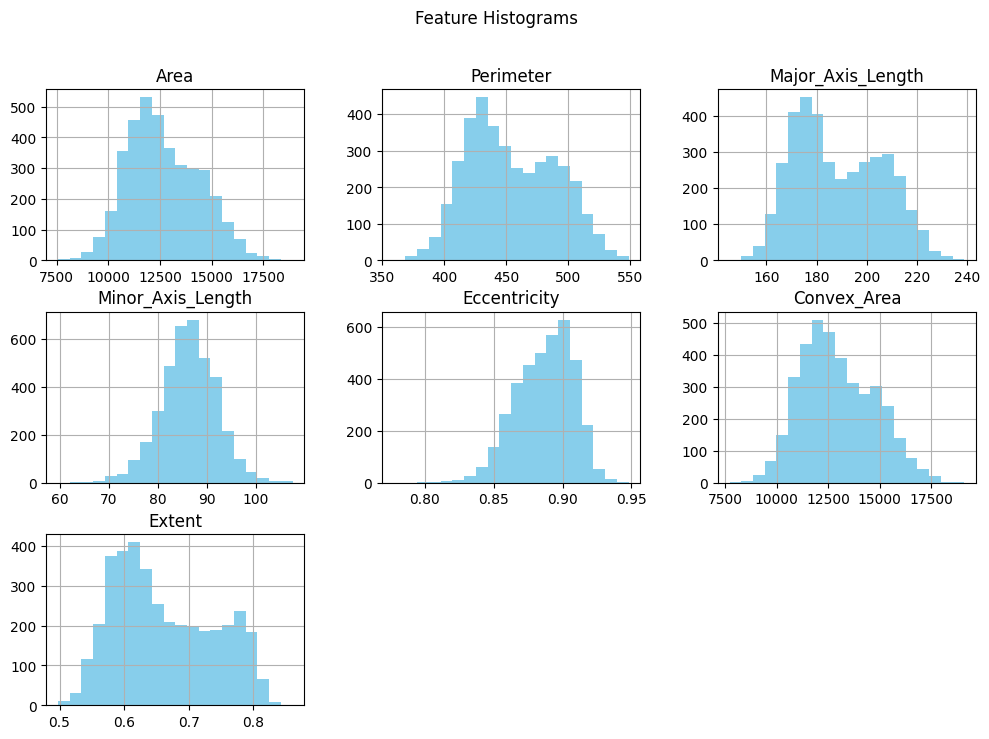

In [8]:
# Histograms for each feature
df.hist(bins=20, figsize=(12, 8), color='skyblue')
plt.suptitle("Feature Histograms")
plt.show()


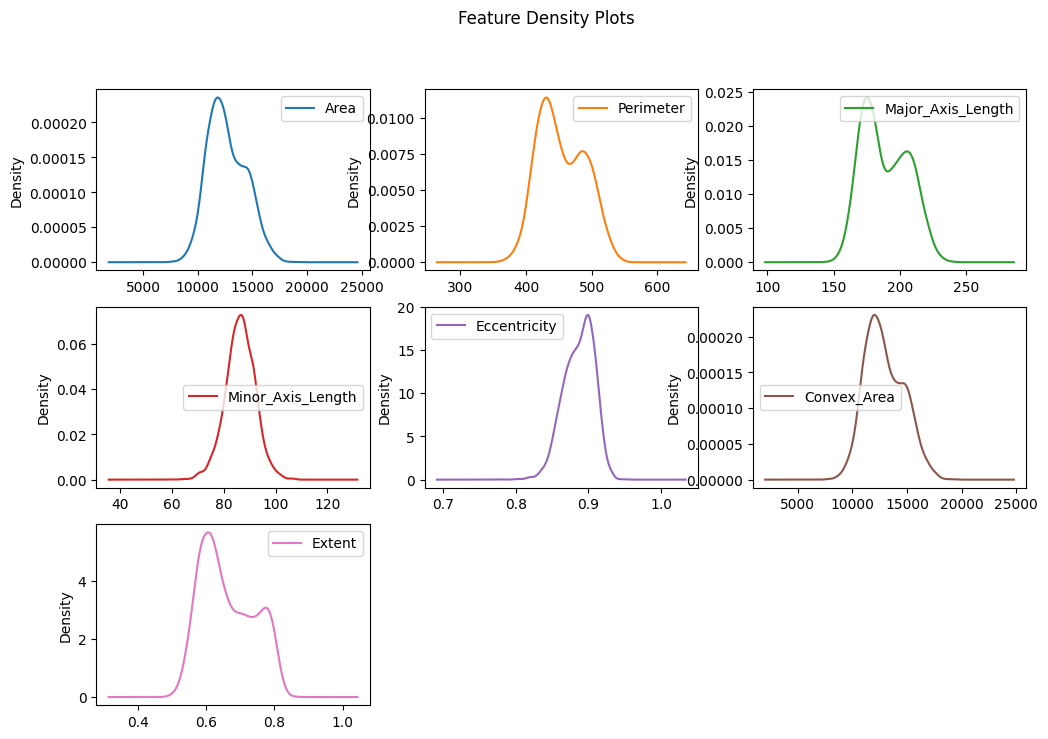

In [9]:
# Density plots for each feature
df.plot(kind='density', subplots=True, layout=(3, 3), sharex=False, figsize=(12, 8))
plt.suptitle("Feature Density Plots")
plt.show()


Class Balance:
Class
1    2180
0    1630
Name: count, dtype: int64


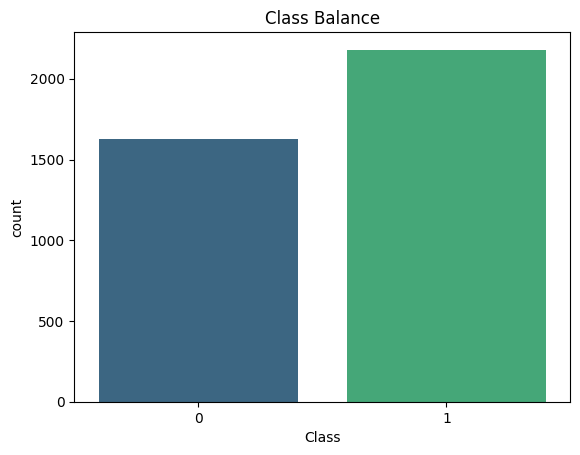

In [16]:
# Check class balance
print("Class Balance:")
print(df['Class'].value_counts())

# Visualize class balance
sns.countplot(data=df, x='Class', palette="viridis")
plt.title("Class Balance")
plt.show()


In [12]:
# Check for missing values
print("Missing Values Per Feature:")
print(df.isnull().sum())

# Fill or drop missing values (if any)
# In this example, we’ll just print if there are any missing values; modify as needed
df = df.dropna()  # If missing values are minimal, drop rows
print("Updated Missing Values Count:")
print(df.isnull().sum())


Missing Values Per Feature:
Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64
Updated Missing Values Count:
Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64


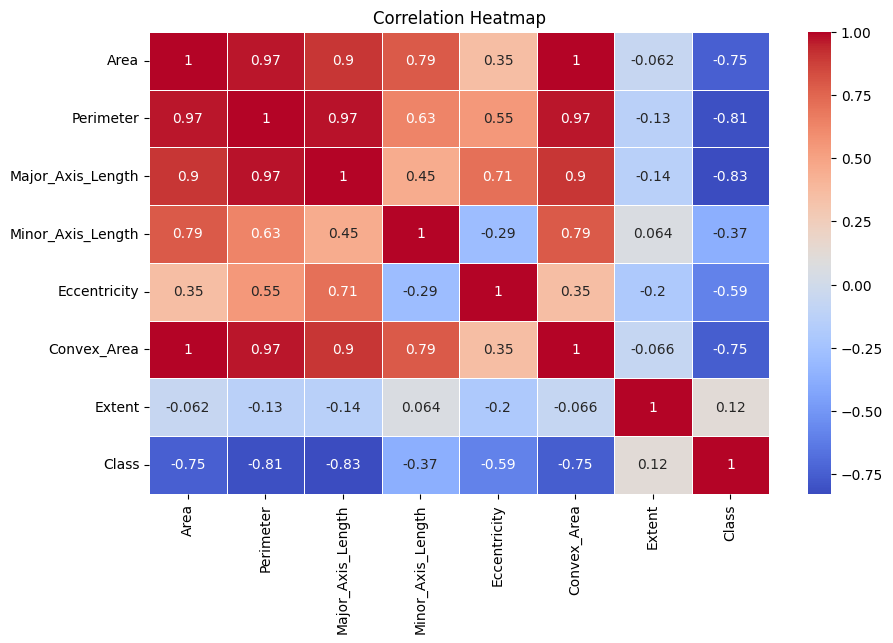

In [18]:
# Filter only numeric features for correlation calculation
numeric_df = df.select_dtypes(include=[np.number])

# Check if there are any numeric columns
if not numeric_df.empty:
    # Generate a correlation heatmap for numeric features
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No numeric columns available for correlation heatmap.")


In [13]:
# Define a function to cap outliers using IQR
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Apply outlier capping
numeric_features = df.select_dtypes(include=[np.number]).columns
df = cap_outliers(df, numeric_features)

# Confirm changes by rechecking the descriptive stats
df.describe()


,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.267454,454.239180,188.776222,86.326474,0.886932,12952.146949,0.661934
std,1730.887966,35.597081,17.448679,5.615361,0.020605,1775.858126,0.077239
min,7551.000000,359.100006,145.264465,71.613723,0.827122,7723.000000,0.497413
25%,11370.500000,426.144753,174.353855,82.731695,0.872402,11626.250000,0.598862
50%,12421.500000,448.852493,185.810059,86.434647,0.889050,12706.500000,0.645361
75%,13950.000000,483.683746,203.550438,90.143677,0.902588,14284.000000,0.726562
max,17819.250000,548.445984,239.010498,101.261649,0.947868,18270.625000,0.861050


In [14]:
# Scale numeric features
scaler = MinMaxScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# Display scaled data
print("Scaled Data (first 5 rows):")
print(df.head())


Scaled Data (first 5 rows):
       Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  0.747937   0.879232           0.901216           0.454671      0.842763   
1  0.691939   0.714095           0.648087           0.678538      0.565512   
2  0.689796   0.750066           0.734349           0.544880      0.703927   
3  0.547805   0.524136           0.512800           0.534090      0.536160   
4  0.695055   0.781992           0.709138           0.596964      0.658980   

   Convex_Area    Extent   Class  
0     0.748415  0.207577  Cammeo  
1     0.696745  0.324564  Cammeo  
2     0.685557  0.538576  Cammeo  
3     0.535192  0.393954  Cammeo  
4     0.714758  0.408680  Cammeo  


In [15]:
# Encode target variable
encoder = LabelEncoder()
df['Class'] = encoder.fit_transform(df['Class'])

# Display encoded classes
print("Encoded Target Variable:")
print(df['Class'].unique())
print("Classes:", encoder.classes_)


Encoded Target Variable:
[0 1]
Classes: ['Cammeo' 'Osmancik']


Logistic Regression Performance:
{'Accuracy': 0.9291338582677166, 'Precision': 0.9204545454545454, 'Recall': 0.9257142857142857, 'F1 Score': 0.9230769230769231}

Classification Report:
               precision    recall  f1-score   support

      Cammeo       0.92      0.93      0.92       350
    Osmancik       0.94      0.93      0.93       412

    accuracy                           0.93       762
   macro avg       0.93      0.93      0.93       762
weighted avg       0.93      0.93      0.93       762

Random Forest Performance:
{'Accuracy': 0.9251968503937008, 'Precision': 0.9221902017291066, 'Recall': 0.9142857142857143, 'F1 Score': 0.9182209469153515}

Classification Report:
               precision    recall  f1-score   support

      Cammeo       0.92      0.91      0.92       350
    Osmancik       0.93      0.93      0.93       412

    accuracy                           0.93       762
   macro avg       0.92      0.92      0.92       762
weighted avg       0.93      0.93  

<Figure size 500x600 with 0 Axes>

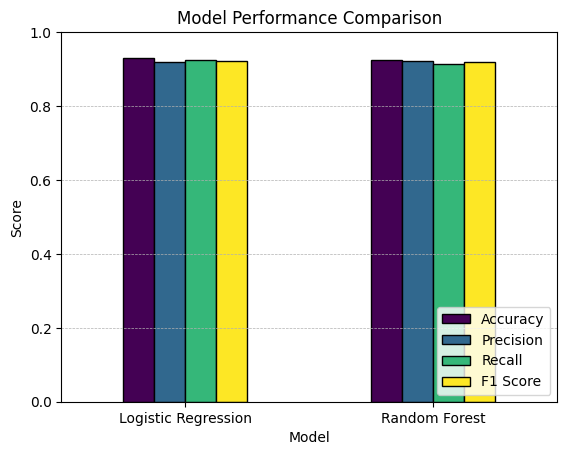

In [7]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt

# Load the .arff file
data, meta = arff.loadarff('/content/Rice_Cammeo_Osmancik.arff')
df = pd.DataFrame(data)

# Convert binary class values to string if needed
df['Class'] = df['Class'].str.decode('utf-8')

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for both training and testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Logistic Regression model
log_reg = LogisticRegression()

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_log_reg = log_reg.predict(X_test)

# Evaluate Logistic Regression performance
log_reg_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_log_reg),
    "Precision": precision_score(y_test, y_pred_log_reg, pos_label="Cammeo"),
    "Recall": recall_score(y_test, y_pred_log_reg, pos_label="Cammeo"),
    "F1 Score": f1_score(y_test, y_pred_log_reg, pos_label="Cammeo")
}

# Print Logistic Regression Performance
print("Logistic Regression Performance:")
print(log_reg_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg))


######################################

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_rf = rf_clf.predict(X_test)

# Evaluate Random Forest performance
rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, pos_label="Cammeo"),
    "Recall": recall_score(y_test, y_pred_rf, pos_label="Cammeo"),
    "F1 Score": f1_score(y_test, y_pred_rf, pos_label="Cammeo")
}

# Print Random Forest Performance
print("Random Forest Performance:")
print(rf_metrics)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


######################################

# Combine metrics into a DataFrame for easy plotting
metrics_df = pd.DataFrame({
    "Logistic Regression": log_reg_metrics,
    "Random Forest": rf_metrics
})

# Transpose DataFrame to make it easier to plot
metrics_df = metrics_df.T

# Plot metrics for both models
plt.figure(figsize=(5, 6))
metrics_df.plot(kind="bar", rot=0, colormap="viridis", edgecolor="black")
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.show()
